In [1]:
!git clone git://github.com/HaoranLv/yolov5_sagemaker.git

Cloning into 'yolov5_sagemaker'...
remote: Enumerating objects: 382, done.
remote: Counting objects: 100% (382/382), done.
remote: Compressing objects: 100% (330/330), done.
remote: Total 382 (delta 55), reused 358 (delta 35), pack-reused 0
Receiving objects: 100% (382/382), 34.69 MiB | 7.42 MiB/s, done.
Resolving deltas: 100% (55/55), done.


# 环境配置

下载源代码，安装所需依赖，验证环境是否安装正确。

In [3]:
!git clone git://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt  # install dependencies

import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.9.1+cu102 (Tesla V100-SXM2-16GB)


# 模型以及数据准备

下载已经训练完成的模型文件、训练数据以及数据配置文件

In [25]:
!aws s3 cp s3://lhr/bestxl.pt ./
!aws s3 cp s3://lhr/sku.zip ./os2d/ 
!aws s3 cp s3://lhr/os2d.yaml ./data/
%cd os2d 
!unzip sku.zip > /dev/null
%cd ..
!cp /home/ec2-user/SageMaker/xilian/yolov5_sagemaker/test.jpg ./

# 模型训练


In [ ]:
!python train.py --img 640 --batch 16 --epochs 1 --data os2d.yaml --weights bestxl.pt --cache

# 模型测试

测试上述步骤中训练得到的模型

In [13]:
!python detect.py --iou-thres 0.6 --conf-thres 0.4 --weights './runs/train/exp/weights/best.pt' --img 640 --source './test.jpg'

detect: weights=['./runs/train/exp/weights/best.pt'], source=./test2.jpg, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.6, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-16-g6d9b99f torch 1.9.1+cu102 CUDA:0 (Tesla V100-SXM2-16GB, 16160.5MB)

Fusing layers... 
Model Summary: 606 layers, 141419080 parameters, 0 gradients, 222.2 GFLOPs
image 1/1 /home/ec2-user/SageMaker/xilian/yolov5/test2.jpg: 640x512 2 AHyzhywqpss, 3 ksbtwsdqpss, 2 nfsqrxxjwsdqpss, 2 qqdqtwsdqpss, 3 sqbbbtwqpss, 2 tqdbtwsdqpss, 2 sqbbxgwqpss, 2 nfsqfxbtwsdqpss, 1 yqslkmjwsdqpsA, 1 yqslbtwsdqpsA, 3 sodazyqtqpss, 2 wxqpbtwqpss, 4 yqslbtwsdqpss, 2 xcgsbtwwtqpss, 3 xcjfptwwtqpss, 3 wxqpbxgwqpss, 3 HPhppnmfwqpss, 2 nfsqcjygwsdqpss, 4 ksnmwsdqpss, 2 xchyyzww

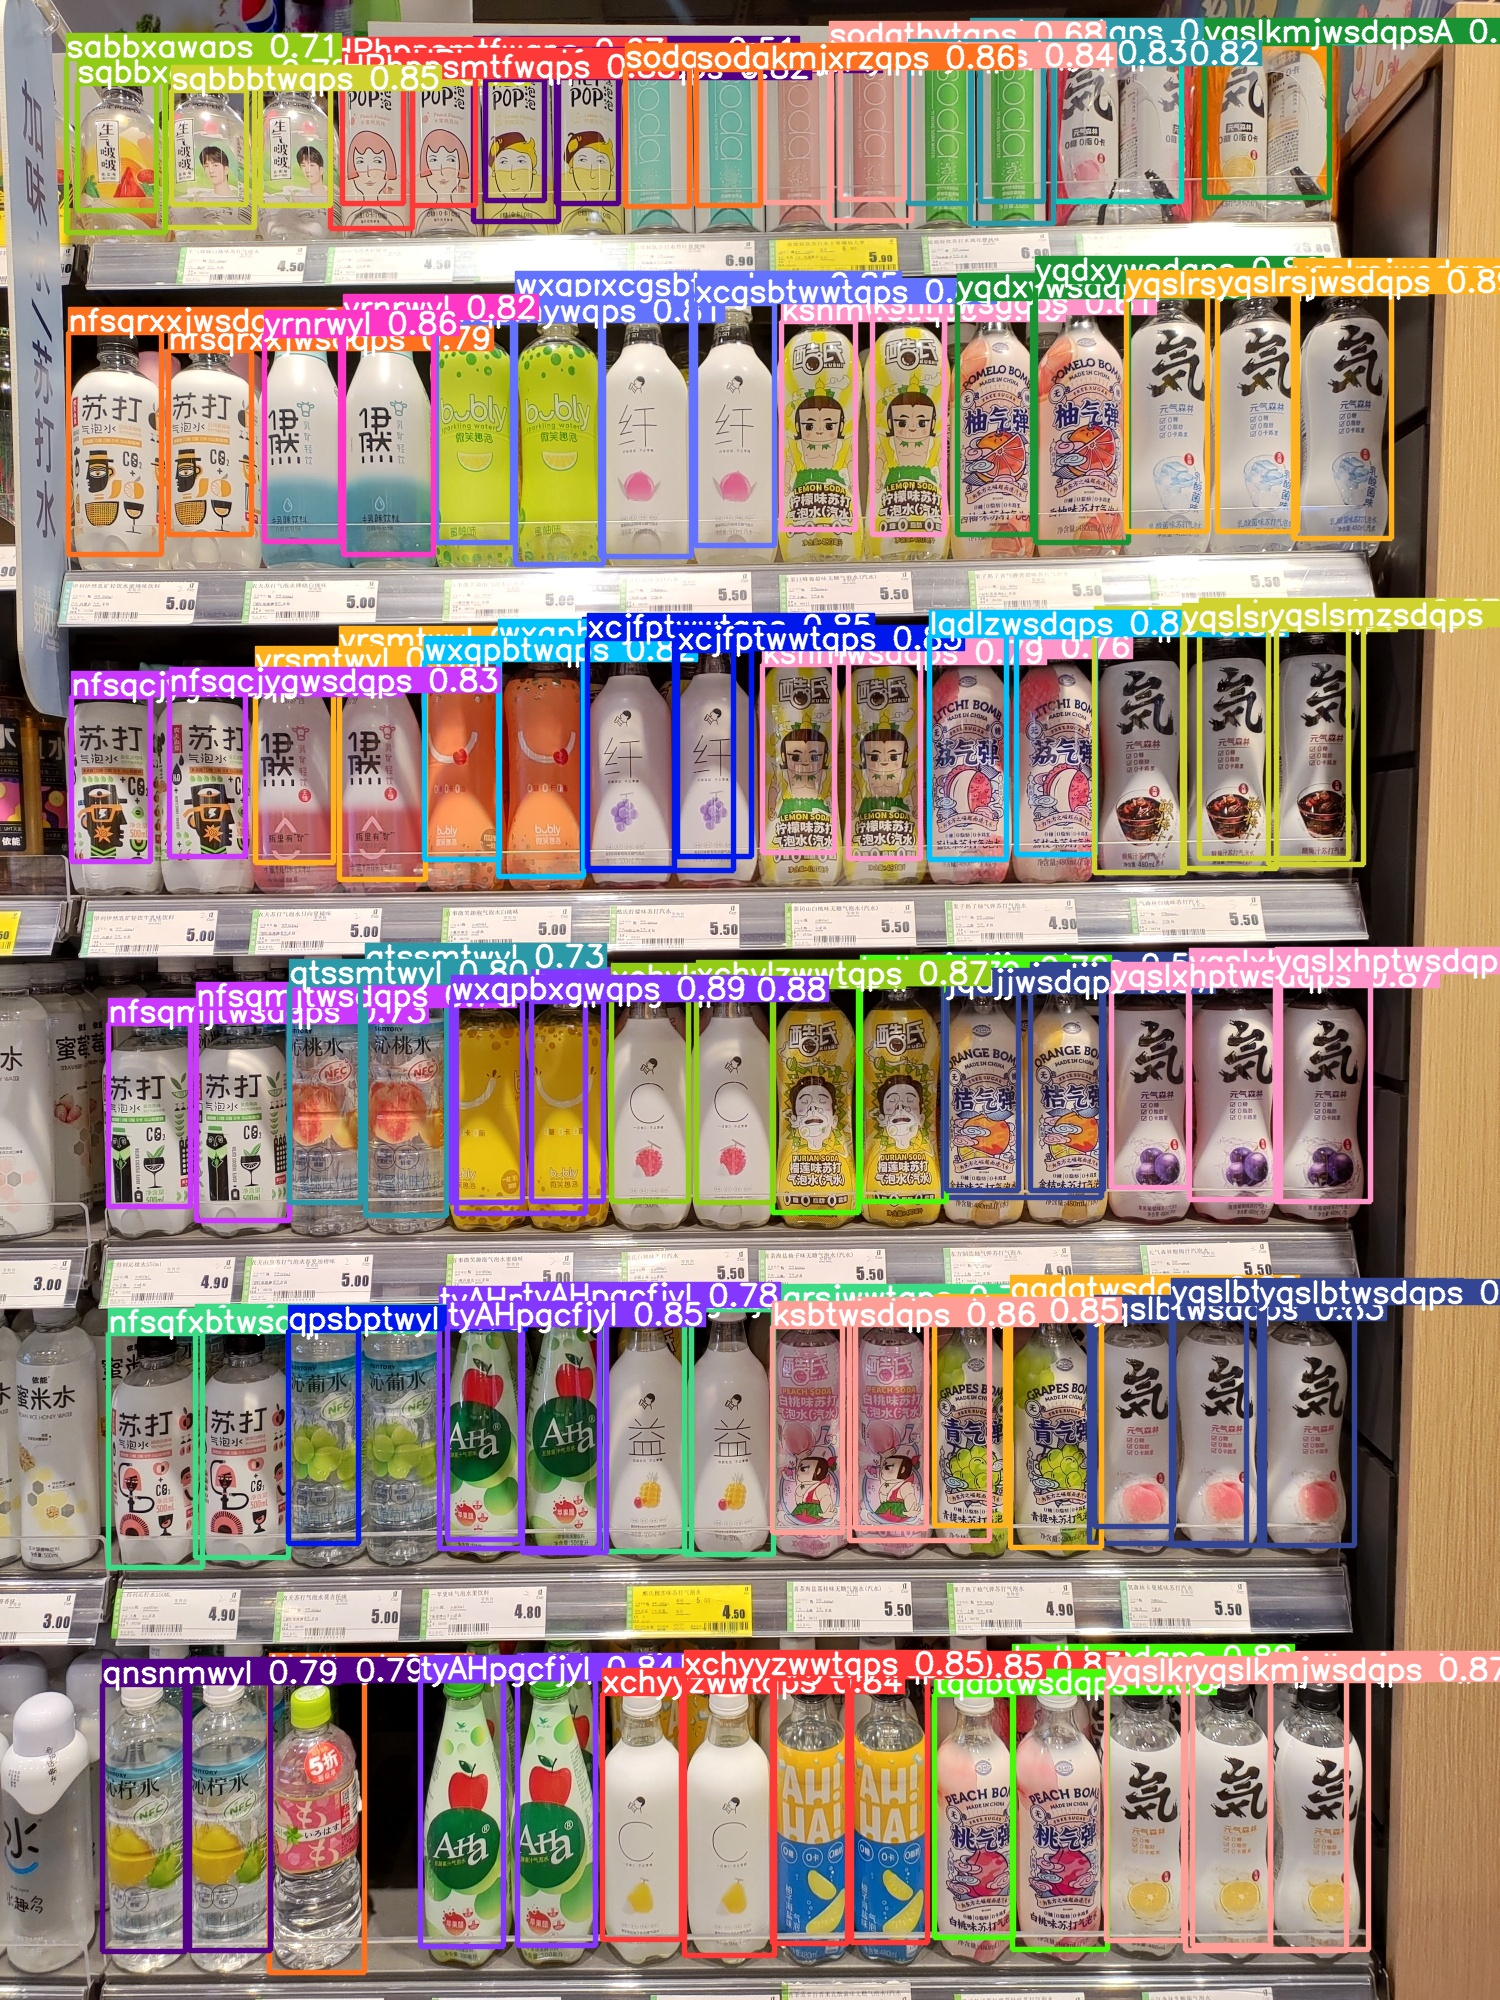

In [14]:
Image(filename='runs/detect/exp/test.jpg', width=1000)

# 模型部署

In [3]:
!cp /home/ec2-user/SageMaker/xilian/yolov5/runs/train/exp/weights/best.pt /home/ec2-user/SageMaker/xilian/yolov5_sagemaker/
%cd /home/ec2-user/SageMaker/xilian/yolov5_sagemaker
!sh build_and_push.sh yolov5

In [ ]:
!python create_endpoint.py

# Endpoint的使用

In [4]:

import boto3
import cv2
import time
import cv2
import json
import ast
import numpy as np
body = b""
with open("./test.jpg", "rb") as fp:
    body = fp.read()
# body = cv2.imencode(".jpg", frame)[1].tobytes()
runtime = boto3.client("sagemaker-runtime",region_name="cn-north-1")
response = runtime.invoke_endpoint(
    EndpointName='yolov5',
    Body=body,
    ContentType='application/x-image',
)
body = json.loads(response["Body"].read().decode())
print(len(body))
print(body)

89
['37 0.100667 0.559 0.0613333 0.119', '31 0.704333 0.37375 0.0566667 0.1375', '39 0.261333 0.21925 0.06 0.1285', '27 0.431667 0.715 0.054 0.13', '6 0.081 0.076 0.062 0.09', '27 0.486333 0.7145 0.054 0.132', '26 0.433 0.5485 0.0566667 0.135', '20 0.486667 0.91 0.056 0.146', '40 0.249333 0.07125 0.048 0.0955', '31 0.646 0.37475 0.056 0.1365', '22 0.211667 0.91325 0.062 0.1465', '17 0.075 0.38875 0.0633333 0.1185', '17 0.137667 0.38775 0.0606667 0.1165', '40 0.297667 0.071 0.0473333 0.095', '26 0.489333 0.54825 0.056 0.1345', '7 0.164667 0.7225 0.0586667 0.126', '10 0.675 0.06625 0.0446667 0.0945', '1 0.540333 0.71475 0.054 0.1315', '18 0.605667 0.21225 0.0566667 0.1385', '5 0.649667 0.90925 0.0566667 0.1475', '36 0.151667 0.90975 0.0566667 0.1545', '42 0.486667 0.068 0.0466667 0.097', '25 0.600333 0.5485 0.0553333 0.131', '16 0.392333 0.07025 0.046 0.0935', '7 0.104667 0.723 0.06 0.124', '25 0.544333 0.54875 0.0553333 0.1325', '5 0.706333 0.908 0.058 0.148', '11 0.364333 0.381 0.05666